<a href="https://colab.research.google.com/github/JeffBaksa/capstone2/blob/main/loadingin_and_models(colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import Model
#import efficientnet.keras as effnet

from datetime import datetime
from skimage import io, color, filters
from skimage.transform import resize, rotate

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#tf.__version__
#keras.__version__

In [ ]:
#!pip install -U efficientnet

## Tensorboard Setup

In [4]:
%load_ext tensorboard

In [3]:
# Tensorboard set up
logdir = 'drive/MyDrive/capstone2/logs/image/' + datetime.now().strftime("%Y%m%d-%H%M%S") # delete datetime?
tensorboard_callback = TensorBoard(log_dir = logdir, histogram_freq=1)

In [ ]:
#%tensorboard  --logdir ./logs/image/20210714-150445

## Loading in Data

In [7]:
# image data generator & flow from dir
train_path = 'drive/MyDrive/capstone2/images/train'
test_path = 'drive/MyDrive/capstone2/images/test'
valid_path = 'drive/MyDrive/capstone2/images/validation'
bs = 16

In [8]:
train_batches = ImageDataGenerator(rescale=1/255, horizontal_flip=True, vertical_flip=True, shear_range=0.2, rotation_range=60).flow_from_directory(train_path, target_size=(224, 224), batch_size=bs)

Found 1635 images belonging to 2 classes.


In [9]:
test_batches = ImageDataGenerator(rescale=1/255).flow_from_directory(test_path, target_size=(224, 224), batch_size=bs)

Found 205 images belonging to 2 classes.


In [10]:
valid_batches = ImageDataGenerator(rescale=1/255).flow_from_directory(valid_path, target_size=(224, 224), batch_size=bs)

Found 204 images belonging to 2 classes.


In [11]:
test_batches2 = ImageDataGenerator(rescale=1/255).flow_from_directory(test_path, target_size=(224, 224), batch_size=4)

Found 205 images belonging to 2 classes.


## Helper Functions

In [44]:
def image_plot_predict(rows, batch, model, cols=bs):  
    """ 
    Plots images with thier predicted class and actual class  
  
    Used after model has been fit to see results of test data
  
    Parameters: 
    rows (int): number of rows for the images displayed
    batch (ImageDataGenerator): test batch of pictures that will be predicted in model
    model : the model training images have been trained on to be used to predict test images
    cols (int) : number of columns displayed ( set to batch size )
    
    
    Returns: 
    plot: Plot of images with their predicted class and their actual class
    """
    types = ['Not Poison Ivy', 'Poison Ivy']
    fig, axs = plt.subplots(rows,cols,figsize=(cols * 3,rows * 4))
    for i in range(rows):
        images, labels = next(batch)
        predictions = model.predict(images)
        for j, pic in enumerate(images):
            title = 'Predicted: ' + types[list(predictions[j]).index(predictions[j].max())] + ' ' + '\n' + 'Actual: ' + types[list(labels[j]).index(1)] + '\n' + 'Confidence: ' + str(predictions[j].max().round(2))
            if rows > 1:
                axs[i,j].imshow(pic)
                axs[i,j].set_title(title)
                axs[i,j].axis('off')
                if types[list(predictions[j]).index(predictions[j].max())] != types[list(labels[j]).index(1)]:
                  axs[i,j].set_title(title, color='red')
            else:
                axs[j].imshow(pic)
                axs[j].set_title(title)
                axs[j].axis('off')
                if types[list(predictions[j]).index(predictions[j].max())] != types[list(labels[j]).index(1)]:
                  axs[i,j].set_title(title, color='red')
    plt.tight_layout()
    plt.show()

In [45]:
def con_fu(rows, test_batches, model):
    """ 
    Collects data for confusion_matrix 
  
    Used in conjunction with sklearn.metrics confusion_matrix function
  
    Parameters: 
    rows (int): number of pictures will be predicted on
    test_batches (ImageDataGenerator) : the pictures that will be predicted
    model : the model training images have been trained on to be used to predict test images
    
    
    
    Returns: 
    l (list) : list of actual class per image
    o (list) : list of predicted class per image
    miss_class (list) : list of images that were missclassified
    """
    l = []
    o = []
    miss_class = []
    miss_predictions = []
    for i in range(rows):
      images, labels = next(test_batches)
      predictions = model.predict(images)
      for j, h in enumerate(labels):
        act_ = list(h).index(1.)
        pred_ = list(predictions[j]).index(predictions[j].max())
        l.append(act_)
        o.append(pred_)
        if act_ != pred_:
          miss_class.append(images[j])
          miss_predictions.append([act_, pred_])
    return l, o, miss_class, miss_predictions

## Display Image / Categories / EDA

In [ ]:
# for image in train_batches:
#     print(image)

In [ ]:
poison_ivy = io.imread('drive/MyDrive/capstone2/images/train/poison_ivy/103.jpg')
poison_ivy2 = io.imread('drive/MyDrive/capstone2/images/train/poison_ivy/360261.jpg')
poison_ivy3 = io.imread('drive/MyDrive/capstone2/images/train/poison_ivy/360440.jpg')
poison_ivy4 = io.imread('drive/MyDrive/capstone2/images/train/poison_ivy/360316.jpg')
poison_ivy5 = io.imread('drive/MyDrive/capstone2/images/train/poison_ivy/360967.jpg')

rasp = io.imread('drive/MyDrive/capstone2/images/train/not_poison_ivy/rasp_4561.jpg')
virgc = io.imread('drive/MyDrive/capstone2/images/train/not_poison_ivy/vc52.jpg')
boxeld = io.imread('drive/MyDrive/capstone2/images/train/not_poison_ivy/be05.jpg')
bostivy = io.imread('drive/MyDrive/capstone2/images/train/not_poison_ivy/bi40.jpg')
skunk = io.imread('drive/MyDrive/capstone2/images/train/not_poison_ivy/sk7 7.jpg')

In [ ]:
#poison_ivy.shape

In [ ]:
#rasp.shape

In [ ]:
poison_ivy = resize(poison_ivy, (300, 300))
poison_ivy2 = resize(poison_ivy2, (300, 300))
poison_ivy3 = resize(poison_ivy3, (300, 300))
poison_ivy4 = resize(poison_ivy4, (300, 300))
poison_ivy5 = resize(poison_ivy5, (300, 300))

rasp = resize(rasp, (300, 300))
virgc = resize(virgc, (300, 300))
boxeld = resize(boxeld, (300, 300))
bostivy = resize(bostivy, (300, 300))
skunk = resize(skunk, (300, 300))

Text(0.5, 1.0, 'Skunkbush')

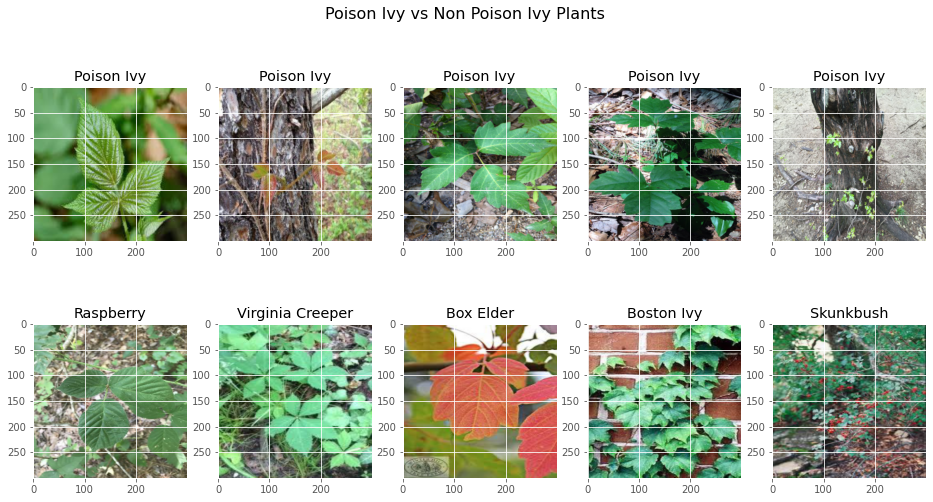

In [ ]:
# Plot An Example of Poison Ivy vs Not Poison Ivy images being used
fig, ax = plt.subplots(2, 5, figsize=(16, 8))
ax[0, 0].imshow(poison_ivy)
ax[0, 1].imshow(poison_ivy2)
ax[0, 2].imshow(poison_ivy3)
ax[0, 3].imshow(poison_ivy4)
ax[0, 4].imshow(poison_ivy5)
ax[1, 0].imshow(rasp)
ax[1, 1].imshow(virgc)
ax[1, 2].imshow(boxeld)
ax[1, 3].imshow(bostivy)
ax[1, 4].imshow(skunk)

# Set titles, labels, etc.
fig.suptitle('Poison Ivy vs Non Poison Ivy Plants', fontsize=16)
ax[0, 0].set_title('Poison Ivy')
ax[0, 1].set_title('Poison Ivy')
ax[0, 2].set_title('Poison Ivy')
ax[0, 3].set_title('Poison Ivy')
ax[0, 4].set_title('Poison Ivy')
ax[1, 0].set_title('Raspberry')
ax[1, 1].set_title('Virginia Creeper')
ax[1, 2].set_title('Box Elder')
ax[1, 3].set_title('Boston Ivy')
ax[1, 4].set_title('Skunkbush')

#plt.savefig('presentation_images/pi_vs_nonpi.jpg')

## Build Baseline Model

In [5]:
# Building Baseline Model
base_model = keras.Sequential()

# Convolutional layer and maxpool layer 1
base_model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
base_model.add(keras.layers.MaxPool2D(2,2))
# Convolutional layer and maxpool layer 2
base_model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
base_model.add(keras.layers.MaxPool2D(2,2))
# This layer flattens the resulting image array to 1D array
base_model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
# model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for not poison ivy or 1 for poison ivy
# Here we use sigmoid activation function which makes our model output to lie between 0 and 1
opt = SGD(learning_rate=0.0001)
base_model.add(keras.layers.Dense(2, activation='sigmoid'))
base_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

base_es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)

# Save the file name
checkpoint_path = "drive/MyDrive/capstone2/checkpoints/base/cp-{epoch:04d}.ckpt" # all the trained weights
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint
base_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    verbose = 1, 
    save_weights_only = True,
    save_best_only = True, # only save the best epoch
    monitor = 'val_accuracy',
    save_freq = 'epoch') # after each epoch

In [ ]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 373250    
Total params: 392,642
Trainable params: 392,642
Non-trainable params: 0
________________________________________________

In [12]:
base_history = base_model.fit(train_batches, validation_data=valid_batches, epochs=100, callbacks=[base_checkpoint, base_es, tensorboard_callback], verbose=1)

Epoch 1/100
103/103 [==============================] - 870s 8s/step - loss: 0.6934 - accuracy: 0.5052 - val_loss: 0.6890 - val_accuracy: 0.5490

Epoch 00001: val_accuracy improved from -inf to 0.54902, saving model to drive/MyDrive/capstone2/checkpoints/base/cp-0001.ckpt
Epoch 2/100
103/103 [==============================] - 28s 272ms/step - loss: 0.6907 - accuracy: 0.5492 - val_loss: 0.6873 - val_accuracy: 0.5490

Epoch 00002: val_accuracy did not improve from 0.54902
Epoch 3/100
103/103 [==============================] - 27s 264ms/step - loss: 0.6900 - accuracy: 0.5486 - val_loss: 0.6864 - val_accuracy: 0.5490

Epoch 00003: val_accuracy did not improve from 0.54902
Epoch 4/100
103/103 [==============================] - 27s 266ms/step - loss: 0.6896 - accuracy: 0.5486 - val_loss: 0.6858 - val_accuracy: 0.5490

Epoch 00004: val_accuracy did not improve from 0.54902
Epoch 5/100
103/103 [==============================] - 26s 256ms/step - loss: 0.6900 - accuracy: 0.5486 - val_loss: 0.6857

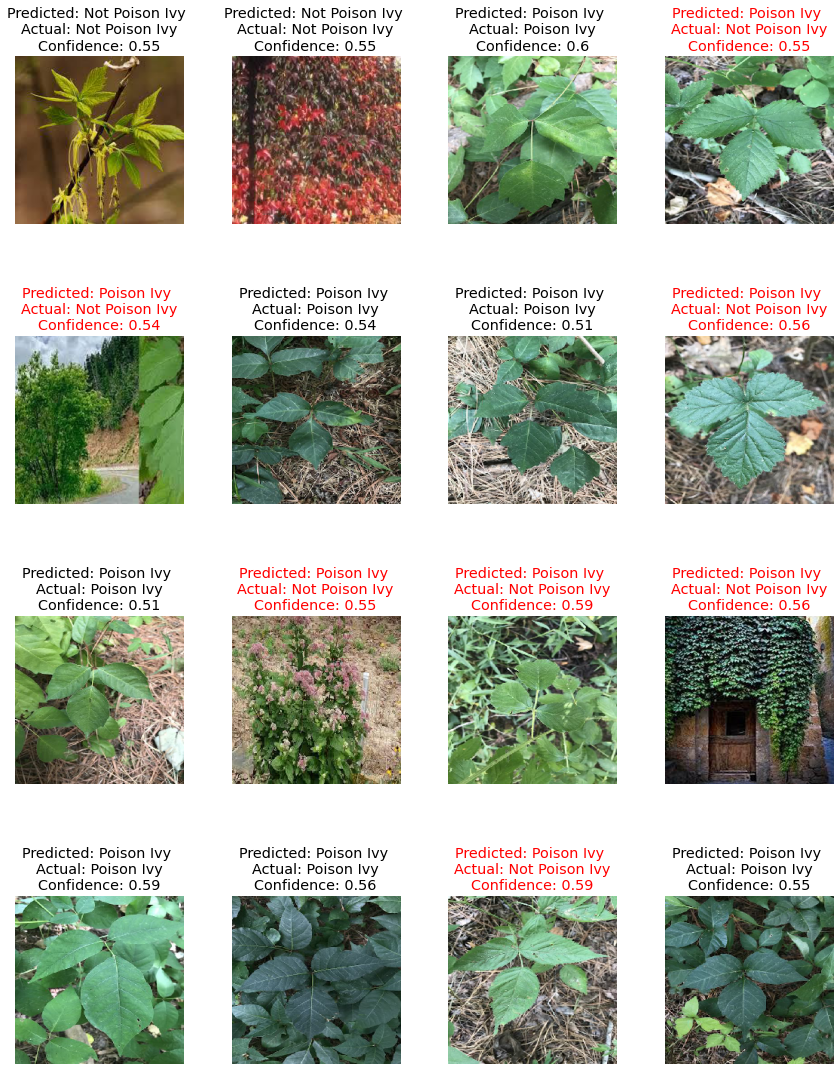

In [110]:
# Baseline Model Predictions
image_plot_predict(4, test_batches2, base_model, cols=4)

In [ ]:
base_history.history

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
fig.suptitle('Baseline Loss and Accuracy', fontsize=20)
# Plot the loss
ax.plot(np.sqrt(base_history.history['loss']), 'orange', label='train')
ax.plot(np.sqrt(base_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(base_history.history['accuracy']), 'orange', label='train')
ax.plot(np.sqrt(base_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [84]:
# Loading in the model from a specific checkpoint
base_model.load_weights('drive/MyDrive/capstone2/checkpoints/base/cp-0085.ckpt')
loss, acc = base_model.evaluate(valid_batches, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
print("Restored model, loss: {:5.2f}".format(loss))

13/13 [==============================] - 1s 72ms/step - loss: 0.6533 - accuracy: 0.6618
Restored model, accuracy: 66.18%
Restored model, loss:  0.65


In [109]:
# Used w/ confusion matrix
base_actual, base_predictions, base_pics, base_miss_predictions = con_fu(250, test_batches, base_model)

In [ ]:
# Accuracy on Test/Holdout Set
print(accuracy_score(base_actual, base_predictions)*100)

55.64291148871418


Text(0.5, 15.0, 'Predictions')

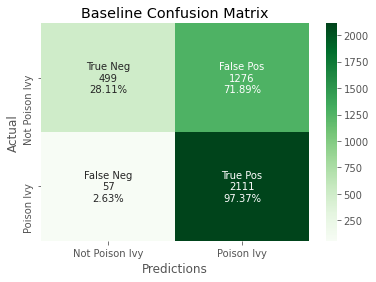

In [111]:
base_cf = confusion_matrix(base_actual, base_predictions, labels=[0, 1])
types = ['Not Poison Ivy', 'Poison Ivy']

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in base_cf.flatten()]
group_percentages_0 = ["{0:.2%}".format(value) for value in base_cf.flatten()/np.sum(base_cf[0])]
group_percentages_1 = ["{0:.2%}".format(value) for value in base_cf.flatten()[2:]/np.sum(base_cf[1])]
group_percentages = np.concatenate([group_percentages_0[:2], group_percentages_1])

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(base_cf, xticklabels=types, yticklabels=types, annot=labels, fmt='', cmap='Greens')
#sns.heatmap(base_cf/np.sum(base_cf), xticklabels=types, yticklabels=types, annot=True, fmt='.2%', cmap='Greens')
plt.title('Baseline Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predictions')

## VGG Model 1 & 2

In [ ]:
# VGG Model
vgg = tf.keras.applications.vgg16.VGG16()

model = Sequential()

for layer in vgg.layers[:-1]:
    model.add(layer)

for layer in model.layers[:-1]:
    layer.trainable = False

# Defining Model
n_classes = 2
opt = SGD(learning_rate=0.0001)
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fitting the Model
vgg_history = model.fit(train_batches, validation_data=valid_batches, epochs=5, verbose=1)

Epoch 1/5
103/103 [==============================] - 232s 2s/step - loss: 2.5519 - accuracy: 0.5674 - val_loss: 0.6591 - val_accuracy: 0.7402
Epoch 2/5
103/103 [==============================] - 267s 3s/step - loss: 0.5888 - accuracy: 0.7112 - val_loss: 0.9056 - val_accuracy: 0.4853
Epoch 3/5
103/103 [==============================] - 259s 3s/step - loss: 0.5859 - accuracy: 0.7257 - val_loss: 0.5967 - val_accuracy: 0.6961
Epoch 4/5
103/103 [==============================] - 213s 2s/step - loss: 0.5548 - accuracy: 0.7294 - val_loss: 0.6545 - val_accuracy: 0.5686
Epoch 5/5
103/103 [==============================] - 213s 2s/step - loss: 0.4986 - accuracy: 0.7561 - val_loss: 0.5967 - val_accuracy: 0.6961


In [ ]:
vgg_history.history

{'loss': [2.551922559738159,
  0.5888381004333496,
  0.585919201374054,
  0.5548318028450012,
  0.4985816776752472],
 'accuracy': [0.5673543810844421,
  0.7111650705337524,
  0.7257281541824341,
  0.7293689250946045,
  0.7560679316520691],
 'val_loss': [0.6591393947601318,
  0.905603289604187,
  0.5967260003089905,
  0.6544623970985413,
  0.596733570098877],
 'val_accuracy': [0.7401960492134094,
  0.4852941036224365,
  0.6960784196853638,
  0.5686274766921997,
  0.6960784196853638]}

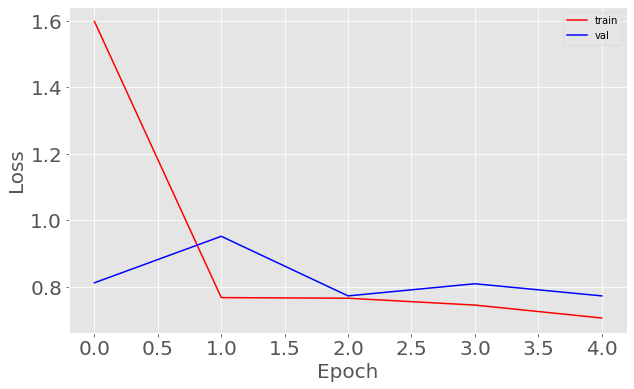

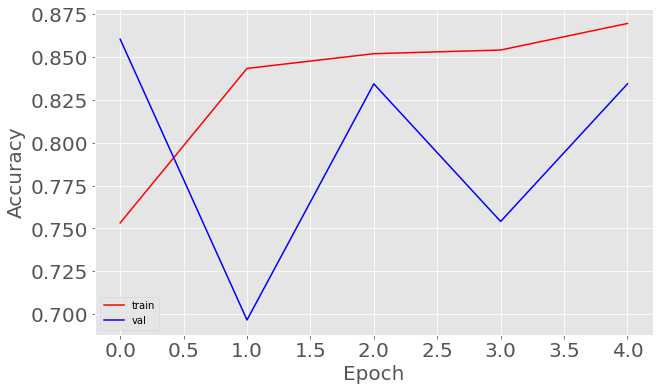

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# Plot the loss
ax.plot(np.sqrt(vgg_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(vgg_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(vgg_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(vgg_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
# VGG w/ adam optimizer
vgg = tf.keras.applications.vgg16.VGG16()

model2 = Sequential()

for layer in vgg.layers[:-1]:
    model2.add(layer)

for layer in model2.layers[:-1]:
    layer.trainable = False

# Defining Model
n_classes = 2
model2.add(Dense(n_classes, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the Model
vgg_history2 = model2.fit(train_batches, validation_data=valid_batches, epochs=2, verbose=1)

Epoch 1/2
103/103 [==============================] - 28s 254ms/step - loss: 1.8550 - accuracy: 0.5615 - val_loss: 0.8026 - val_accuracy: 0.6127
Epoch 2/2
103/103 [==============================] - 42s 405ms/step - loss: 0.7800 - accuracy: 0.6428 - val_loss: 0.8399 - val_accuracy: 0.5882


In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

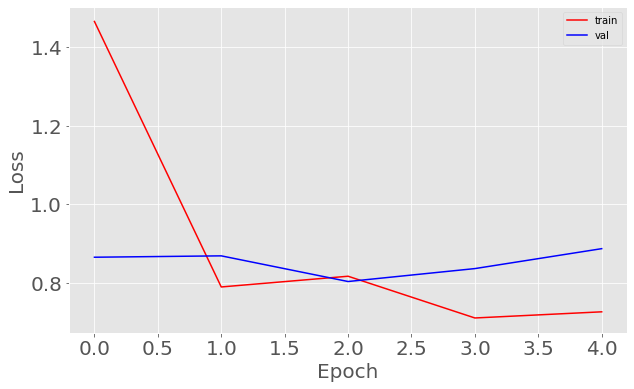

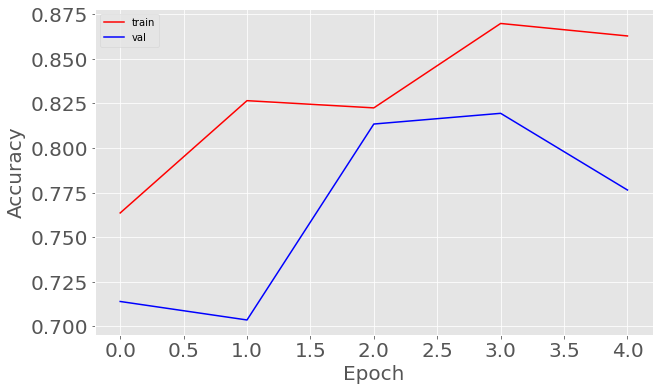

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# Plot the loss
ax.plot(np.sqrt(vgg_history2.history['loss']), 'r', label='train')
ax.plot(np.sqrt(vgg_history2.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(vgg_history2.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(vgg_history2.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
#%reload_ext tensorboard

In [ ]:
# Tensorboard set up
logdir = 'drive/MyDrive/capstone2/logs/image/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = logdir, histogram_freq=1)

In [ ]:
#%tensorboard  --logdir ./logs/image/20210714-150445

## VGG Model 3 w/ Predictions

In [13]:
vgg = tf.keras.applications.vgg16.VGG16()
model3 = Sequential()

for layer in vgg.layers[:-3]:  
    model3.add(layer)
for layer in model3.layers:
    layer.trainable = False

# Defining Additional Model Layers
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(.1)) # helps prevent overfitting
# model3.add(Dense(256, activation='relu'))
# model3.add(Dropout(.1))
model3.add(Dense(2, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer=Adam(.001), metrics=['accuracy'])

# Early Stopping
vgg3_es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# Save the file name
checkpoint_path = "drive/MyDrive/capstone2/checkpoints/vgg3/cp-{epoch:04d}.ckpt" # all the trained weights
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint
vgg3_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    verbose = 1, 
    save_weights_only = True,
    save_best_only = True, # only save the best epoch
    monitor = 'val_accuracy',
    save_freq = 'epoch') # after epoch

553467904/553467096 [==============================] - 14s 0us/step


In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
# Fitting the Model
vgg_history3 = model3.fit(train_batches, validation_data=valid_batches, epochs=50, callbacks=[vgg3_checkpoint, vgg3_es, tensorboard_callback], verbose=1)

Epoch 1/50
103/103 [==============================] - 27s 259ms/step - loss: 0.8353 - accuracy: 0.6165 - val_loss: 0.7629 - val_accuracy: 0.4265

Epoch 00001: val_accuracy improved from -inf to 0.42647, saving model to drive/MyDrive/capstone2/checkpoints/vgg3/cp-0001.ckpt
Epoch 2/50
103/103 [==============================] - 27s 260ms/step - loss: 0.5844 - accuracy: 0.6972 - val_loss: 0.6305 - val_accuracy: 0.6765

Epoch 00002: val_accuracy improved from 0.42647 to 0.67647, saving model to drive/MyDrive/capstone2/checkpoints/vgg3/cp-0002.ckpt
Epoch 3/50
103/103 [==============================] - 27s 258ms/step - loss: 0.5306 - accuracy: 0.7425 - val_loss: 0.7880 - val_accuracy: 0.6422

Epoch 00003: val_accuracy did not improve from 0.67647
Epoch 4/50
103/103 [==============================] - 26s 256ms/step - loss: 0.5016 - accuracy: 0.7584 - val_loss: 0.5874 - val_accuracy: 0.7206

Epoch 00004: val_accuracy improved from 0.67647 to 0.72059, saving model to drive/MyDrive/capstone2/chec

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# Plot the loss
ax.plot(np.sqrt(vgg_history3.history['loss']), 'r', label='train')
ax.plot(np.sqrt(vgg_history3.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(vgg_history3.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(vgg_history3.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [14]:
# Loading in the model from a specific checkpoint
abc = model3.load_weights('drive/MyDrive/capstone2/checkpoints/vgg3/cp-0013.ckpt')
loss, acc = model3.evaluate(valid_batches, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
print("Restored model, loss: {:5.2f}".format(loss))

13/13 [==============================] - 91s 6s/step - loss: 0.4237 - accuracy: 0.8333
Restored model, accuracy: 83.33%
Restored model, loss:  0.42


In [15]:
abc_history = model3.fit(train_batches, validation_data=valid_batches, epochs=50, callbacks=[vgg3_checkpoint, vgg3_es, tensorboard_callback], verbose=1)

Epoch 1/50
103/103 [==============================] - 777s 8s/step - loss: 0.3890 - accuracy: 0.8312 - val_loss: 0.5282 - val_accuracy: 0.7304

Epoch 00001: val_accuracy improved from -inf to 0.73039, saving model to drive/MyDrive/capstone2/checkpoints/vgg3/cp-0001.ckpt
Epoch 2/50
103/103 [==============================] - 28s 270ms/step - loss: 0.3690 - accuracy: 0.8373 - val_loss: 0.6067 - val_accuracy: 0.7206

Epoch 00002: val_accuracy did not improve from 0.73039
Epoch 3/50
103/103 [==============================] - 27s 266ms/step - loss: 0.3547 - accuracy: 0.8477 - val_loss: 0.5580 - val_accuracy: 0.7745

Epoch 00003: val_accuracy improved from 0.73039 to 0.77451, saving model to drive/MyDrive/capstone2/checkpoints/vgg3/cp-0003.ckpt
Epoch 4/50
103/103 [==============================] - 28s 270ms/step - loss: 0.3643 - accuracy: 0.8440 - val_loss: 0.8055 - val_accuracy: 0.6225

Epoch 00004: val_accuracy did not improve from 0.77451
Epoch 5/50
103/103 [==============================]

In [ ]:
#model3.predict(test_batches).round(3)

In [ ]:
#model3.predict_on_batch(test_batches[0][0]).round(3)

In [ ]:
#test_batches[0][1]

In [ ]:
# image = test_batches[0] # first batch
# plt.imshow(image[0][1]) # second num is what image

In [ ]:
# fig, ax = plt.subplots(4, 4, figsize=(16,10))
# ax[0, 0].imshow(image[0][0])
# ax[0, 1].imshow(image[0][1])
# ax[0, 2].imshow(image[0][2])
# ax[0, 3].imshow(image[0][3])
# ax[1, 0].imshow(image[0][4])
# ax[1, 1].imshow(image[0][5])
# ax[1, 2].imshow(image[0][6])
# ax[1, 3].imshow(image[0][7])
# ax[2, 0].imshow(image[0][8])
# ax[2, 1].imshow(image[0][9])
# ax[2, 2].imshow(image[0][10])
# ax[2, 3].imshow(image[0][11])
# ax[3, 0].imshow(image[0][12])
# ax[3, 1].imshow(image[0][13])
# ax[3, 2].imshow(image[0][14])
# ax[3, 3].imshow(image[0][15])

# fig.suptitle('Poison Ivy Predictions vs Actual', fontsize=16)
# # Titles
# ax[0, 0].set_title('')
# ax[0, 1].set_title('')
# ax[0, 2].set_title('')
# ax[0, 3].set_title('')
# ax[1, 0].set_title('')
# ax[1, 1].set_title('')
# ax[1, 2].set_title('')
# ax[1, 3].set_title('')
# ax[2, 0].set_title('')
# ax[2, 1].set_title('')
# ax[2, 2].set_title('')
# ax[2, 3].set_title('')
# ax[3, 0].set_title('')
# ax[3, 1].set_title('')
# ax[3, 2].set_title('')
# ax[3, 3].set_title('')

In [ ]:
# predictions = model3.predict_on_batch(test_batches[0][0])
# labels = test_batches[0][1]

# for idx, p in enumerate(predictions):
#   if p[0] > p[1]:
#     print(idx, p[0])
#   else:
#     print(idx, p[1])

In [ ]:
# fig, ax = plt.subplots(4, 4, figsize=(16,10))

# for k in range(0, 4): 
#   for i in range(bs):
#     for j in range(0, 4):
#       print(f"j = {j}")
#       print(f"k = {k}")
#       print(f"i = {i}")
#       print('End of loop')
#       ax[j, k].imshow(image[0][i])

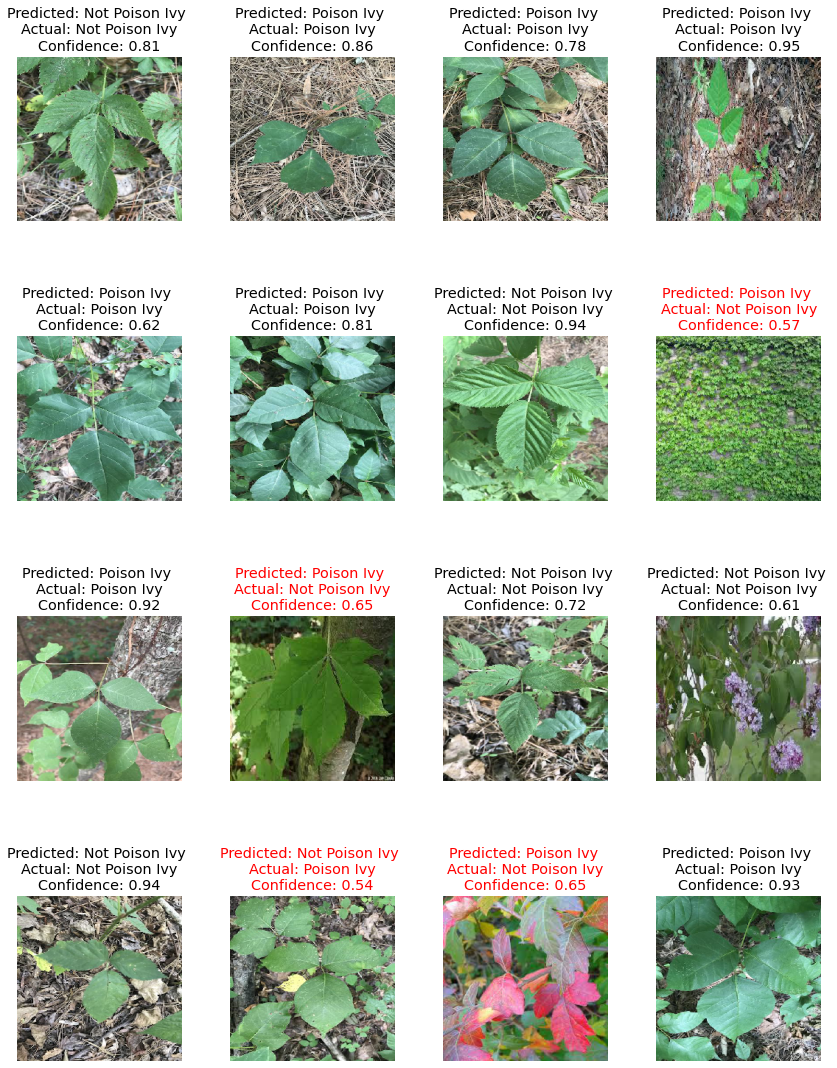

In [ ]:
# VGG16 Model3 Predictions of One Batch
image_plot_predict(4, test_batches2, model3, cols=4)

In [ ]:
# Used w/ confusion matrix
model3_actual, model3_predictions, model3_pics, model3_miss_predictions = con_fu(250, test_batches, model3) # can increase the number to however many times you want to run it

In [ ]:
# Accuracy on Test/Holdout Set
print(accuracy_score(model3_actual, model3_predictions)*100)

74.13137205173726


In [ ]:
vgg3_cf = confusion_matrix(model3_actual, model3_predictions, labels=[0, 1])
types = ['Not Poison Ivy', 'Poison Ivy']

Text(33.0, 0.5, 'Actual')

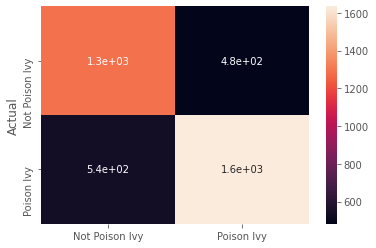

In [ ]:
sns.heatmap(vgg3_cf, xticklabels=types, yticklabels=types, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predictions')

## VGG Model 4

In [88]:
vgg = tf.keras.applications.vgg16.VGG16()
model4 = Sequential()

for layer in vgg.layers[:-3]:  
    model4.add(layer)
for layer in model4.layers:
    layer.trainable = False

# Defining Additional Model Layers
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(.2)) # helps prevent overfitting
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(.2))
model4.add(Dense(2, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer=Adam(.001), metrics=['accuracy']) 

# Tensorboard Callback
vgg4_tb_callback = TensorBoard(log_dir = logdir, histogram_freq=1)

# Early Stopping
vgg4_es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, restore_best_weights=True)

# Save the file name
checkpoint_path = "drive/MyDrive/capstone2/checkpoints/vgg4_ver2/cp-{epoch:04d}.ckpt" # all the trained weights
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint
vgg4_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    verbose = 1, 
    save_weights_only = True,
    save_best_only = True, # only save the best epoch
    monitor = 'val_accuracy',
    save_freq = 'epoch') # after epoch

In [17]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [89]:
vgg_history4 = model4.fit(train_batches, validation_data=valid_batches, epochs=100, callbacks=[vgg4_checkpoint, vgg4_es, vgg4_tb_callback], verbose=1)

Epoch 1/100
103/103 [==============================] - 30s 287ms/step - loss: 0.9662 - accuracy: 0.5731 - val_loss: 0.5795 - val_accuracy: 0.7402

Epoch 00001: val_accuracy improved from -inf to 0.74020, saving model to drive/MyDrive/capstone2/checkpoints/vgg4_ver2/cp-0001.ckpt
Epoch 2/100
103/103 [==============================] - 30s 291ms/step - loss: 0.5903 - accuracy: 0.6972 - val_loss: 0.6757 - val_accuracy: 0.6225

Epoch 00002: val_accuracy did not improve from 0.74020
Epoch 3/100
103/103 [==============================] - 28s 269ms/step - loss: 0.5490 - accuracy: 0.7131 - val_loss: 0.5534 - val_accuracy: 0.7255

Epoch 00003: val_accuracy did not improve from 0.74020
Epoch 4/100
103/103 [==============================] - 28s 273ms/step - loss: 0.5618 - accuracy: 0.7144 - val_loss: 0.6228 - val_accuracy: 0.6912

Epoch 00004: val_accuracy did not improve from 0.74020
Epoch 5/100
103/103 [==============================] - 27s 264ms/step - loss: 0.5295 - accuracy: 0.7376 - val_loss:

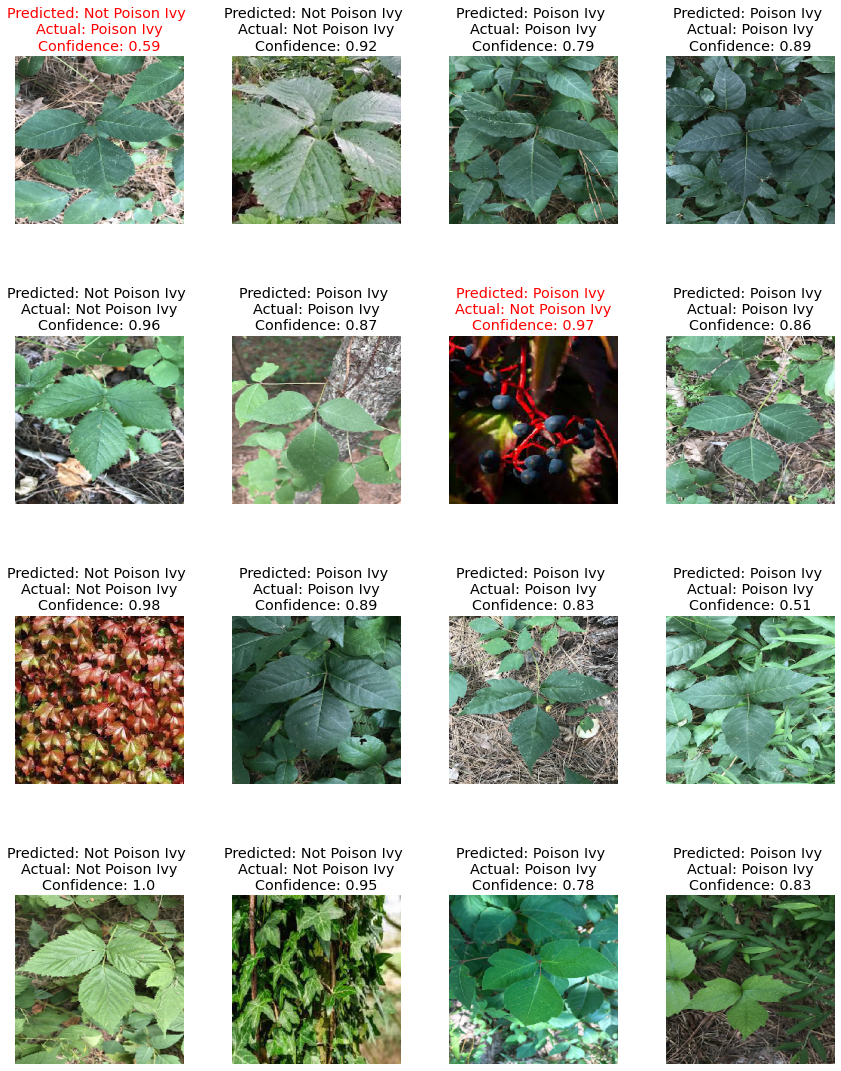

In [ ]:
image_plot_predict(4, test_batches2, model4, cols=4)

In [ ]:
vgg_history4.history

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
fig.suptitle('VGG16 Loss and Accuracy', fontsize=20)
# Plot the loss
ax.plot(np.sqrt(vgg_history4.history['loss']), 'orange', label='train')
ax.plot(np.sqrt(vgg_history4.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(vgg_history4.history['accuracy']), 'orange', label='train')
ax.plot(np.sqrt(vgg_history4.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [29]:
# Loading in the model from a specific checkpoint
model4.load_weights('drive/MyDrive/capstone2/checkpoints/vgg4/cp-0038.ckpt')
loss, acc = model4.evaluate(valid_batches, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

13/13 [==============================] - 2s 142ms/step - loss: 0.4139 - accuracy: 0.8725
Restored model, accuracy: 87.25%


In [46]:
# Used w/ confusion matrix
model4_actual, model4_predictions, model4_pics, model4_miss_predictions = con_fu(250, test_batches, model4) # can increase the number to however many times you want to run it

In [ ]:
# Accuracy on Test/Holdout Set
print(accuracy_score(model4_actual, model4_predictions)*100)

78.60406091370558


Text(0.5, 15.0, 'Predictions')

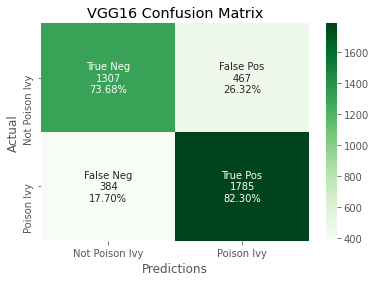

In [64]:
vgg4_cf = confusion_matrix(model4_actual, model4_predictions, labels=[0, 1])
types = ['Not Poison Ivy', 'Poison Ivy']

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in vgg4_cf.flatten()]
group_percentages_0 = ["{0:.2%}".format(value) for value in vgg4_cf.flatten()/np.sum(vgg4_cf[0])]
group_percentages_1 = ["{0:.2%}".format(value) for value in vgg4_cf.flatten()[2:]/np.sum(vgg4_cf[1])]
group_percentages = np.concatenate([group_percentages_0[:2], group_percentages_1])

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(vgg4_cf, xticklabels=types, yticklabels=types, annot=labels, fmt='', cmap='Greens')
plt.title('VGG16 Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predictions')

In [57]:
group_percentages_0 + group_percentages_1

['73.68%', '26.32%', '21.65%', '100.62%', '17.70%', '82.30%']

In [52]:
vgg4_cf[1]

array([ 384, 1785])

## Xception

In [43]:
xcep_model = tf.keras.applications.xception.Xception(input_shape = (224, 224, 3), include_top = False, weights='imagenet')
#xcep_model = tf.keras.applications.xception.Xception(input_shape = (299, 299, 3), include_top = True)

model5 = Sequential()
# for layer in xcep_model.layers[:-2]:
#     model5.add(layer)
# for layer in model5.layers:
#     layer.trainable = False

# Defining Model
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(.1)) # helps prevent overfitting
model5.add(Dense(2, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Tensorboard Callback
logdir = 'drive/MyDrive/capstone2/logs/image/' + datetime.now().strftime("%Y%m%d-%H%M%S") # delete datetime?
xcep_tb_callback = TensorBoard(log_dir = logdir, histogram_freq=1)

# Early Stopping
xcep_es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# Save the file name
checkpoint_path = "drive/MyDrive/capstone2/checkpoints/xcep/cp-{epoch:04d}.ckpt" # all the trained weights
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint
xcep_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    verbose = 1, 
    save_weights_only = True, 
    save_best_only = True, # only save the best epoch
    monitor = 'val_accuracy',
    save_freq = 'epoch') # after epoch

ValueError: ignored

In [39]:
xcep_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [38]:
# Fitting the Model
xcep_history = model5.fit(train_batches, validation_data=valid_batches, epochs=100, callbacks=[xcep_checkpoint, xcep_es, tensorboard_callback], verbose=1)

Epoch 1/100


ValueError: ignored

## ResNet34

In [22]:
from functools import partial

In [23]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [119]:
resn_model = keras.models.Sequential()
resn_model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
resn_model.add(keras.layers.BatchNormalization())
resn_model.add(keras.layers.Activation("relu"))
resn_model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    resn_model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
resn_model.add(keras.layers.GlobalAvgPool2D())
resn_model.add(keras.layers.Flatten())
resn_model.add(keras.layers.Dense(2, activation="sigmoid"))

# Compile model
resn_model.compile(loss='binary_crossentropy', optimizer=Adam(.001), metrics=['accuracy'])

# Tensorboard Callback
resn_tb_callback = TensorBoard(log_dir = logdir, histogram_freq=1)

# Early Stopping
resn_es = EarlyStopping(monitor='loss', patience=20, verbose=1)

# Save checkpoint file name
checkpoint_path = "drive/MyDrive/capstone2/checkpoints/resnet_ver3/cp-{epoch:04d}.ckpt" # all the trained weights
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint
resn_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    verbose = 1, 
    save_weights_only = True,
    save_best_only = True, 
    monitor = 'val_accuracy',
    save_freq = 'epoch')

In [ ]:
resn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_72 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_32 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_33 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_34 (ResidualUn (None, 56, 56, 64)       

In [120]:
resn_history = resn_model.fit(train_batches, validation_data=valid_batches, epochs=100, callbacks=[resn_checkpoint, resn_es, resn_tb_callback], verbose=1)

Epoch 1/100
103/103 [==============================] - 32s 274ms/step - loss: 0.7732 - accuracy: 0.5719 - val_loss: 0.8758 - val_accuracy: 0.4951

Epoch 00001: val_accuracy improved from -inf to 0.49510, saving model to drive/MyDrive/capstone2/checkpoints/resnet_ver3/cp-0001.ckpt
Epoch 2/100
103/103 [==============================] - 29s 280ms/step - loss: 0.6704 - accuracy: 0.6018 - val_loss: 0.7727 - val_accuracy: 0.5637

Epoch 00002: val_accuracy improved from 0.49510 to 0.56373, saving model to drive/MyDrive/capstone2/checkpoints/resnet_ver3/cp-0002.ckpt
Epoch 3/100
103/103 [==============================] - 29s 278ms/step - loss: 0.6723 - accuracy: 0.6012 - val_loss: 0.7148 - val_accuracy: 0.5245

Epoch 00003: val_accuracy did not improve from 0.56373
Epoch 4/100
103/103 [==============================] - 27s 265ms/step - loss: 0.6556 - accuracy: 0.6275 - val_loss: 1.4448 - val_accuracy: 0.3922

Epoch 00004: val_accuracy did not improve from 0.56373
Epoch 5/100
103/103 [==========

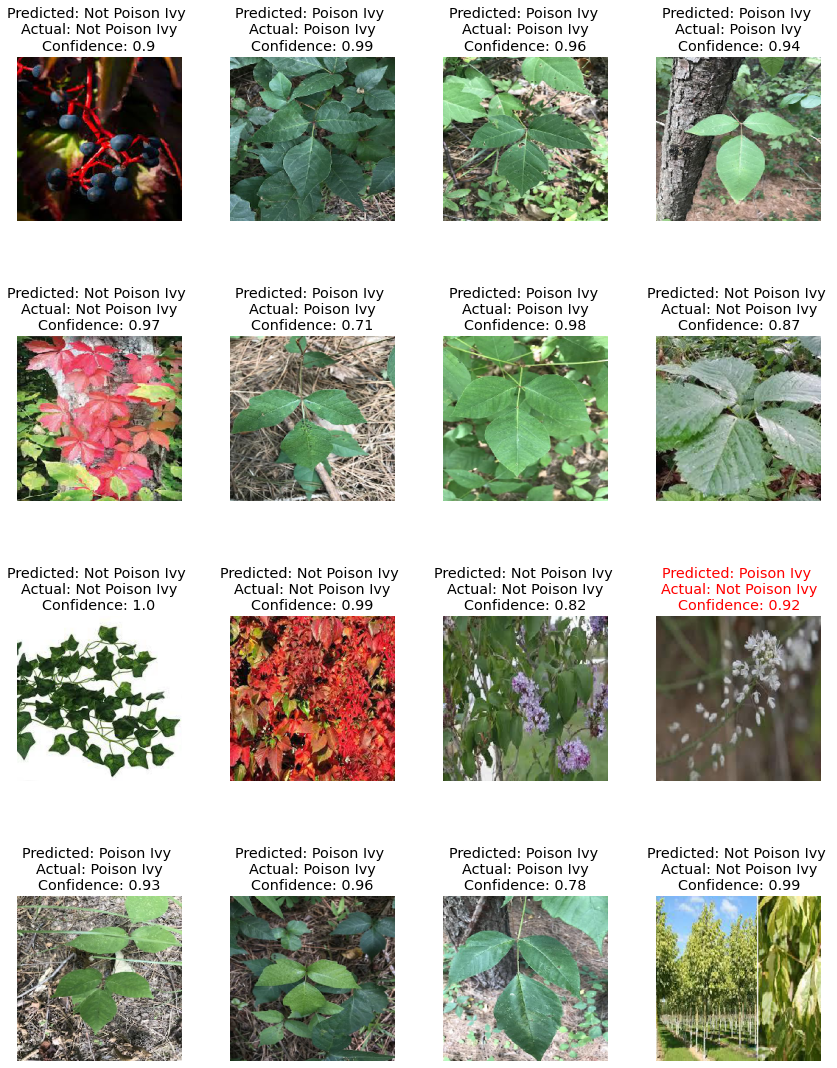

In [126]:
image_plot_predict(4, test_batches2, resn_model, cols=4)

In [99]:
# Loading in the model from a specific checkpoint
resn_model.load_weights('drive/MyDrive/capstone2/checkpoints/resnet/cp-0031.ckpt')
loss, acc = resn_model.evaluate(valid_batches, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

13/13 [==============================] - 1s 112ms/step - loss: 0.4354 - accuracy: 0.7892
Restored model, accuracy: 78.92%


In [122]:
# VERSION 2
resn_model.load_weights('drive/MyDrive/capstone2/checkpoints/resnet_ver2/cp-0069.ckpt')
loss, acc = resn_model.evaluate(valid_batches, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

13/13 [==============================] - 1s 71ms/step - loss: 0.3943 - accuracy: 0.8186
Restored model, accuracy: 81.86%


In [102]:
# Used w/ confusion matrix
resn_actual, resn_predictions, resn_pics, resn_miss_predictions = con_fu(250, test_batches, resn_model) # can increase the number to however many times you want to run it

Text(0.5, 15.0, 'Predictions')

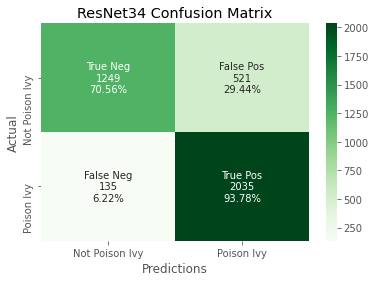

In [103]:
resn_cf = confusion_matrix(resn_actual, resn_predictions, labels=[0, 1])
types = ['Not Poison Ivy', 'Poison Ivy']

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in resn_cf.flatten()]
group_percentages_0 = ["{0:.2%}".format(value) for value in resn_cf.flatten()/np.sum(resn_cf[0])]
group_percentages_1 = ["{0:.2%}".format(value) for value in resn_cf.flatten()[2:]/np.sum(resn_cf[1])]
group_percentages = np.concatenate([group_percentages_0[:2], group_percentages_1])

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(resn_cf, xticklabels=types, yticklabels=types, annot=labels, fmt='', cmap='Greens')
plt.title('ResNet34 Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predictions')

## Evaluating Models

In [114]:
# Loading in the model from a specific checkpoint
model4.load_weights('drive/MyDrive/capstone2/checkpoints/vgg4/cp-0038.ckpt')
loss, acc = model4.evaluate(valid_batches, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

13/13 [==============================] - 1s 110ms/step - loss: 0.4139 - accuracy: 0.8725
Restored model, accuracy: 87.25%


In [116]:
# Base
base_model.evaluate(test_batches)

13/13 [==============================] - 1s 68ms/step - loss: 0.6609 - accuracy: 0.6634


[0.6608876585960388, 0.6634146571159363]

In [115]:
# VGG16 
model4.evaluate(test_batches)

13/13 [==============================] - 1s 70ms/step - loss: 0.5120 - accuracy: 0.7854


[0.5120462775230408, 0.785365879535675]

In [123]:
# ResNet34
resn_model.evaluate(test_batches)

13/13 [==============================] - 1s 68ms/step - loss: 0.4501 - accuracy: 0.8341


[0.45014023780822754, 0.8341463208198547]

## EfficientNetB0

In [ ]:
efn0_model = effnet.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in efn0_model.layers:
    layer.trainable = False

x = efn0_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation="sigmoid")(x)
efn0_final = Model(efn0_model.input, predictions)
efn0_final.compile(optimizers.RMSprop(lr=0.0001,decay=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
efn0_history = efn0_final.fit_generator(train_batches, validation_data=valid_batches, steps_per_epoch=120, epochs=3)

AttributeError: module 'keras.utils' has no attribute 'get_file'

## EfficientNetB7

In [ ]:
efn7_model = effnet.EfficientNetB7(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in efn7_model.layers:
    layer.trainable = False

x2 = efn7_model.output
x2 = Flatten()(x2)
x2 = Dense(32, activation='adam')(x2)
x2 = Dropout(0.5)(x2)
predictions = Dense(n_classes, activation='sigmoid')(x2)
efn7_final = Model(efn7_model.input, predictions)
opt = optimizers.RMSprop(lr=0.0001,decay=1e-6)
efn7_final.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])

efn7_history = efn7_final.fit(train_batches, validation_data=valid_batches, steps_per_epoch=120, epochs=3)